In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator

def read_fried_v2(file_path):
    """Reads a FRIEDv2 grid file, handles trailing commas or mixed delimiters."""
    import re
    col_names = [
        "Host_Mstar_Msol", 
        "R_outer_au", 
        "Sigma_1au_gcm2", 
        "Sigma_outer_gcm2", 
        "FUV_G0", 
        "log10_Mdot_Msol_per_yr"
    ]

    cleaned_rows = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.strip().startswith('#') or not line.strip():
                continue  # skip comments/empty lines
            # Remove trailing commas, split by whitespace
            cleaned_line = re.sub(r',', '', line.strip())
            fields = cleaned_line.split()
            if len(fields) == 6:
                cleaned_rows.append(fields)

    df = pd.DataFrame(cleaned_rows, columns=col_names).astype(float)
    print(f"Loaded {len(df)} rows from '{file_path}'")
    return df
    
def get_exact_mdot(df, Mstar, Rout, SigmaRout, G0):
    """
    Return log10(Mdot) and Mdot for the exact input parameters if found in the DataFrame.
    """
    row = df[
        (df["Host_Mstar_Msol"] == Mstar) &
        (df["R_outer_au"] == Rout) &
        (abs(df["Sigma_outer_gcm2"]-SigmaRout)/SigmaRout<0.1) &
        (df["FUV_G0"] == G0)
    ]
    
    if row.empty:
        print(f"No exact match found for M={Mstar}, Rout={Rout}, Sigmaout={SigmaRout}, G0={G0}")
        return None
    else:
        log10_mdot = row["log10_Mdot_Msol_per_yr"].values[0]
        mdot = 10**log10_mdot
        return log10_mdot

def prepare_interpolator(df):
    """Creates an interpolator over (Mstar, Rout, G0) for log10(Mdot)."""
    # Get unique grid values
    Mstars = np.sort(df["Host_Mstar_Msol"].unique())
    Rout = np.sort(df["R_outer_au"].unique())
    SigmaoutRout = np.round(df["Sigma_outer_gcm2"]*df["R_outer_au"], 1).unique()
    G0s = np.sort(df["FUV_G0"].unique())

    # Reshape log10(Mdot) to 3D grid
    mdot_grid = np.full((len(Mstars), len(Rout), len(SigmaoutRout), len(G0s)), np.nan)

    for a, m in enumerate(Mstars):
        for b, r in enumerate(Rout):
            for c, so in enumerate(SigmaoutRout):
                for d, g in enumerate(G0s):
                    mdot_grid[a, b, c, d] = get_exact_mdot(df, m, r, so/r, g)

    # Remove NaNs safely
    if np.isnan(mdot_grid).any():
        print("Warning: Missing values in grid — interpolation near edges may fail.")

    interpolator = RegularGridInterpolator(
        (Mstars, Rout, SigmaoutRout, G0s), mdot_grid, bounds_error=False, fill_value=None
    )
    return interpolator

def query_mass_loss(interpolator, Mstar, Rout, SigmaRout, G0):
    """Interpolates log10(Mdot) and returns Mdot in Msol/yr."""
    log10_mdot = interpolator([[Mstar, Rout, SigmaRout, G0]])[0]
    return 10**log10_mdot if log10_mdot is not None else None

In [117]:
def float_to_str(fval):
    """Convert float like 0.1 → '0p1', 1.0 → '1p0' for filenames."""
    return f"{fval:.1f}".replace(".", "p")

In [ ]:
# example of interpolation:

f_PAH = [0.1, 0.5, 1]
i=1
PAH_str = float_to_str(f_PAH[i])
file_path = "FRIEDgrid/"+"FRIEDV2_1p0Msol_fPAH"+PAH_str+"_growth.dat"
df = read_fried_v2(file_path)
interpolator = prepare_interpolator(df)

# Query example
Mstar = 1.0
Rout = 5.0
Sigma1au = 1e3
SigmaRout = Sigma1au/Rout
G0 = 100000.0

mdot = query_mass_loss(interpolator, Mstar, Rout, SigmaRout*Rout, G0)
print(f"Mass loss rate is ~ {mdot:.2e} Msun/yr")

Loaded 360 rows from 'FRIEDgrid/FRIEDV2_1p0Msol_fPAH0p5_growth.dat'
Mass loss rate is ~ 1.30e-08 Msun/yr


In [127]:
# example
Mstar = 1.0
Rout = 5.0
SigmaRout = 200.0
G0 = 100000.0

get_exact_mdot(df, Mstar, Rout, SigmaRout, G0)

-7.885772

Loaded 360 rows from 'FRIEDgrid/FRIEDV2_1p0Msol_fPAH0p1_growth.dat'
Loaded 360 rows from 'FRIEDgrid/FRIEDV2_1p0Msol_fPAH0p5_growth.dat'
Loaded 360 rows from 'FRIEDgrid/FRIEDV2_1p0Msol_fPAH1p0_growth.dat'


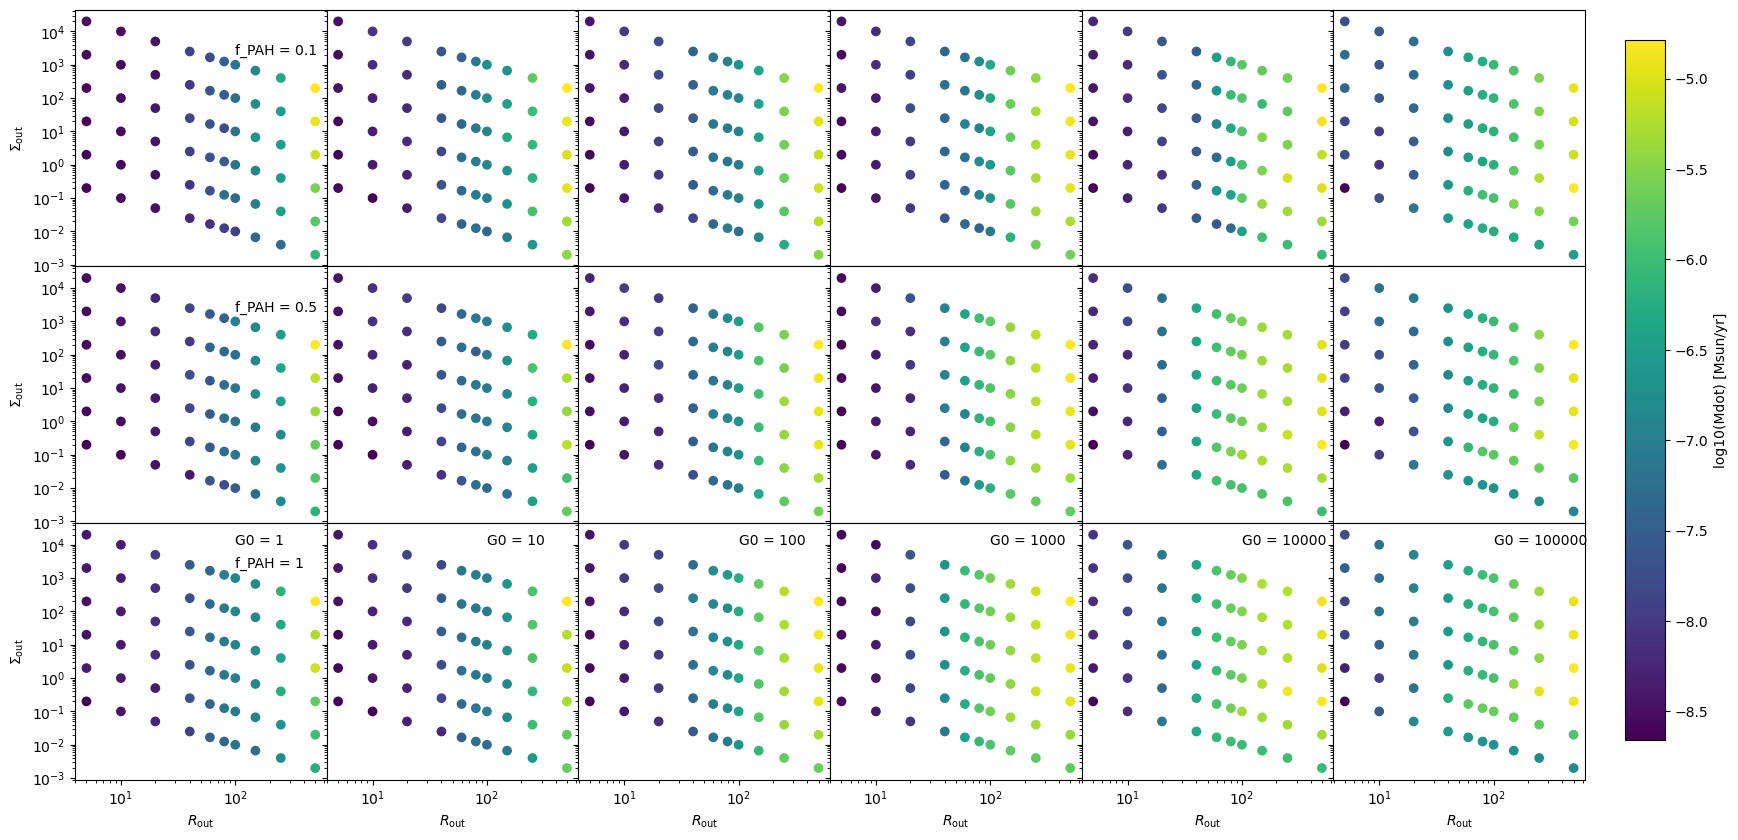

In [ ]:
# reproduce figure A1~A6 in Haworth et al. (2023)
f_PAH = [0.1, 0.5, 1]
Mstar = 1
Routs = [5, 10, 20, 40, 60, 80, 100, 150, 250, 500]
Sigma1aus = [1, 1e1, 1e2, 1e3, 1e4, 1e5]
G0s = [1, 1e1, 1e2, 1e3, 1e4, 1e5]

fig, axes = plt.subplots(len(f_PAH), len(G0s), figsize=(20, 10), sharex=True, sharey=True)
for i, f in enumerate(f_PAH):
    PAH_str = float_to_str(f)
    file_path = "FRIEDgrid/" + f"FRIEDV2_1p0Msol_fPAH{PAH_str}_growth.dat"
    df = read_fried_v2(file_path)
    interpolator = prepare_interpolator(df)

    for l, G0 in enumerate(G0s):
        ax = axes[i, l]
        x_vals, y_vals, c_vals = [], [], []

        for Rout in Routs:
            for Sigma1au in Sigma1aus:
                SigmaRout = Sigma1au / Rout
                mdot = query_mass_loss(interpolator, Mstar, Rout, SigmaRout * Rout, G0)
                if not np.isnan(mdot):
                    x_vals.append(Rout)
                    y_vals.append(SigmaRout)
                    c_vals.append(np.log10(mdot))

        sc = ax.scatter(x_vals, y_vals, c=c_vals, cmap='viridis')
        ax.set_xscale('log')
        ax.set_yscale('log')

        if i == len(f_PAH) - 1:
            ax.text(100, 1e4, f"G0 = {int(G0)}")
            ax.set_xlabel(r'$R_\mathrm{out}$')
        if l == 0:
            ax.text(100, 2e3, f"f_PAH = {f}")
            ax.set_ylabel(r'$\Sigma_\mathrm{out}$')

fig.subplots_adjust(right=0.88, wspace=0., hspace=0.)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cbar_ax, label="log10(Mdot) [Msun/yr]")
# plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()